# 2.1 Sensitivity Analysis

## Introduction

**This section corresponds to Section 4.1 of the original paper.**

The task of explaining a DNN's decision can be rephrased into the following question: given a DNN $f$, input image $x$ and the output of DNN $f(x)$, what is it of $x$ that made the DNN reach the particular decision $f(x)$?

To tackle this problem, we can define a relevance function $R$ that takes in an ith pixel $x_i$ of image $x$ as an argument and returns a scalar value $R(x_i)$ which indicates how much positive or negative contribution $x_i$ has had on the final decision $f(x)$. If the range of $R$ is limited to nonnegative real numbers, 0 indicates no contribution and any other positive scalar indicates positive contribution. Intuitively, the extent of positive/negative contribution must be proportional to the absolute value of $R(x_i)$.

In this section, we ask for a given an image x, which pixel(s) or group(s) of pixels makes it representative of a certain concept encoded in the output neuron of the deep neural network (DNN).

A first approach to identify the most important input features is sensitivity analysis. A common formulation of sensitivity analysis defines relevance scores as

\begin{equation}
R(x_i) = \left( \frac{\partial f}{\partial x_i} \right)^2
\end{equation}

where the gradient is evaluated at the data point $x_i$. Put simply, the relevance score indicates how influential a particular data point was on the DNN's decision. Therefore, the most relevant input features are those to which the output is most sensitive i.e., has high relevance scores. The relevance score can be calculated simply using backpropagation.

However, it is important to note that sensitivity analysis does not provide an explicit explanation of the function value $f(x)$, but rather suggestions. For instance, when applying sensitivity analysis to a DNN detecting cars, we answer the question *"what makes this image more/less a car"* rather than the more basic question *"what makes this image a car?"*. This may not make much sense to you. Let me offer an explanation with a simplified version of sensitivity analysis.

Suppose we have a binary classification function that separates 2-dimensional points into two classes:

\begin{equation}
f(x,y) = 
\begin{cases}
x^2 + y^2 - 9 < 0 & \text{for class N(egative)} \\
x^2 + y^2 - 9 \geq 0 &  \text{for class P(ositive)}
\end{cases}
\end{equation}

For instance, $f(-1,1) = -7 < 0$ and therefore the point $(-1,1)$ is in class $N$. On the other hand, $f(-4,-4) = 7 > 0$ and therefore the point $(-4,-4)$ is in class $P$.

Let us now turn our attention to the gradient of $f$ at points $(-1,1)$ and $(-4,-4)$. The gradient of $f$ is:

\begin{equation}
\nabla f(x,y) = 
\begin{bmatrix}
\partial f / \partial x & \partial f / \partial y
\end{bmatrix} = 
\begin{bmatrix}
2x & 2y
\end{bmatrix}
\end{equation}

The gradient at $(-1,1)$ is given by $\begin{bmatrix}-2 & 2\end{bmatrix}$ and the sensitivity is $\begin{bmatrix}4 & 4\end{bmatrix}$. Note that the sensitivity does not tell *why* $(-1,1)$ is in class $N$. It merely suggests that increasing or decreasing $x$ and $y$ may produce a point that belongs to class $N$ more strongly.

Let's take a look at another example: $(-4,-4)$. The gradient at the point is given by $\begin{bmatrix}-8 & -8\end{bmatrix}$ and therefore the sensitivity is $\begin{bmatrix}64 & 64\end{bmatrix}$. Also in this case, the sensitivity only suggests that increasing or decreasing $x$ and $y$ may produce a point that DNN will classify into class $P$ with higher confidence (see the figure below for a visualization of the points with their normalized gradients indicated by arrows).

Likewise, the sensitivity scores for images do not tell us *why* the DNN made such a decision. It only tells us what changes in the image (e.g. emphasis or de-emphasis of a particular feature) may cause the DNN to classify the image with more certainty into the given class. Looking back, note how apt the name *"sensitivity analysis"* is. Sensitivity analysis tells us how *sensitive* the function value $f(x)$ is to changes in pixel values. The magnitude of sensitivity is quantified by the relevance score $R(x_i)$ given by the square of gradient of $f(x)$ at the pixel $x_i$.

![title](./assets/2_1_SA/contour.png)

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_1 import MNIST_DNN, MNIST_CNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/2_1_SA/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In this step, a CNN classifier is initialized and necessary nodes for model training is added onto the graph. For sensitivity analysis, we only need three placeholders. `training` to indicate that we do not use dropout when during inference, `X` in order to pass test images into the computation graph and `logits` which is necessary to compute the gradient (we need to compute the gradient of `X` with respect to `logits`). Instead of using a fully connected neural network, I used a convolutional neural network because it provided better sensitivity analysis visualization.

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    CNN = MNIST_CNN('CNN')

    # Setup training process
    training = tf.placeholder_with_default(True, shape=[], name='training')
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    logits = CNN(X, training)
    
    tf.add_to_collection('sensitivity_analysis', training)
    tf.add_to_collection('sensitivity_analysis', X)
    tf.add_to_collection('sensitivity_analysis', logits)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=CNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the CNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, training: False}))

sess.close()

Epoch: 0001 cost = 0.755203515 accuracy = 0.744127272
Epoch: 0002 cost = 0.287379274 accuracy = 0.909418183
Epoch: 0003 cost = 0.230599659 accuracy = 0.927818183
Epoch: 0004 cost = 0.198606952 accuracy = 0.937472728
Epoch: 0005 cost = 0.183995720 accuracy = 0.942200003
Epoch: 0006 cost = 0.170081426 accuracy = 0.946763638
Epoch: 0007 cost = 0.165785470 accuracy = 0.948218184
Epoch: 0008 cost = 0.155800372 accuracy = 0.951472731
Epoch: 0009 cost = 0.151487274 accuracy = 0.952563640
Epoch: 0010 cost = 0.145716070 accuracy = 0.954636367
Epoch: 0011 cost = 0.142153567 accuracy = 0.955272730
Epoch: 0012 cost = 0.138724105 accuracy = 0.957436367
Epoch: 0013 cost = 0.140947498 accuracy = 0.957090912
Epoch: 0014 cost = 0.137629085 accuracy = 0.957836368
Epoch: 0015 cost = 0.136273555 accuracy = 0.958454548
Accuracy: 0.9892


### 4. Restoring Subgraph

Here we first rebuild the CNN graph from metagraph, restore CNN parameters from the checkpoint and then gather the necessary nodes for Sensitivity Analysis using the `tf.get_collection()` function. We can calculate the relevance scores using the `tf.square()` and the `tf.gradients()` functions.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

SA = tf.get_collection('sensitivity_analysis')
training = SA[0]
X = SA[1]
logits = SA[2]

SA_scores = [tf.square(tf.gradients(logits[:,i], X)) for i in range(10)]

INFO:tensorflow:Restoring parameters from ./tf_logs/2_1_SA/model


### 5. Calculating Relevance Scores $R_i(x)$

In [5]:
images = mnist.train.images
labels = mnist.train.labels

sample_imgs = []
for i in range(10):
    sample_imgs.append(images[np.argmax(labels, axis=1) == i][3])

hmaps = np.reshape([sess.run(SA_scores[i], feed_dict={X: sample_imgs[i][None,:], training:False}) for i in range(10)], [10, 784])

sess.close()

### 6. Displaying Images

The relevance scores are visualized as heat maps over the original digit images. You can see which features/data points influenced the CNN most its decision making.

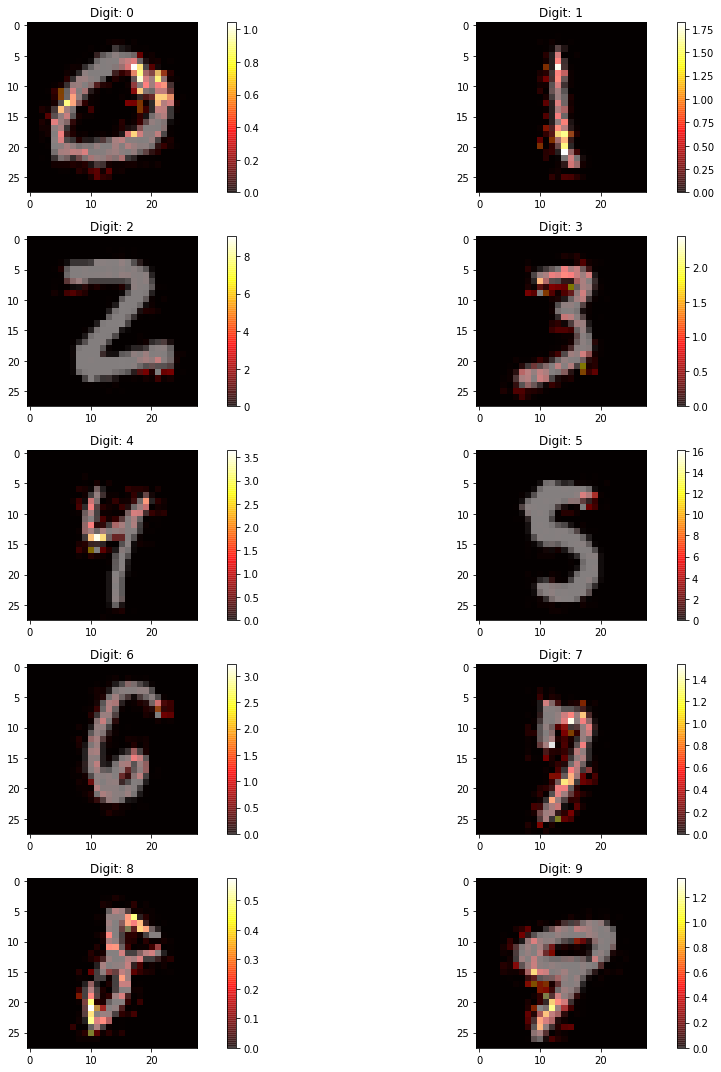

In [6]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(sample_imgs[2 * i], [28, 28]), cmap='gray')
    plt.imshow(np.reshape(hmaps[2 * i], [28, 28]), cmap='hot', alpha=0.5)
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(sample_imgs[2 * i + 1], [28, 28]), cmap='gray')
    plt.imshow(np.reshape(hmaps[2 * i + 1], [28, 28]), cmap='hot', alpha=0.5)
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()